In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('Frozen_Dessert_Production.csv', index_col='DATE', parse_dates=True)

In [6]:
df.columns = ['Production']

In [9]:
df

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632


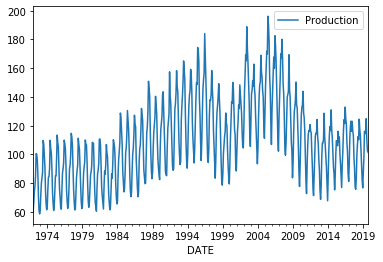

In [10]:
df.plot()

In [11]:
len(df)

573

In [12]:
test_size = 24
test_index = len(df) - test_size

In [13]:
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [14]:
len(train)

549

In [16]:
len(test)

24

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [18]:
scaled_train = scaler.fit(train)

In [20]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [21]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [22]:
length = 18
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [24]:
X, y = generator[0]

In [27]:
X

array([[[0.00947104],
        [0.06108982],
        [0.11326273],
        [0.14145625],
        [0.18982663],
        [0.30495972],
        [0.30154406],
        [0.27416065],
        [0.19736841],
        [0.08532665],
        [0.01561588],
        [0.        ],
        [0.01774221],
        [0.09850931],
        [0.15590133],
        [0.18358944],
        [0.20878908],
        [0.37150354]]])

In [26]:
y

array([[0.3542551]])

In [29]:
# Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [30]:
model = Sequential()

model.add(LSTM(100, input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [33]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

In [34]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [35]:
model.fit_generator(generator, validation_data=validation_generator, epochs=20, callbacks=[early_stop])

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
531/531 [==============================] - 12s 22ms/step - loss: 0.0183 - val_loss: 0.0029
Epoch 2/20
531/531 [==============================] - 11s 20ms/step - loss: 0.0046 - val_loss: 0.0053
Epoch 3/20
531/531 [==============================] - 12s 23ms/step - loss: 0.0035 - val_loss: 0.0055


In [36]:
losses = pd.DataFrame(model.history.history)

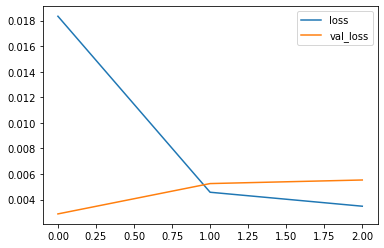

In [37]:
losses.plot()

In [45]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    print(current_pred)
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

[0.24255088]
[0.20813574]
[0.21262796]
[0.2694187]
[0.3450689]
[0.42822602]
[0.49791065]
[0.54578394]
[0.549509]
[0.49878982]
[0.41020218]
[0.31730464]
[0.24764036]
[0.22671126]
[0.24923961]
[0.3188319]
[0.40456423]
[0.49444962]
[0.566937]
[0.61433005]
[0.6208805]
[0.5740642]
[0.47569534]
[0.34978524]


In [46]:
test_predictions_inversed = scaler.inverse_transform(test_predictions)

In [50]:
test['Predictions'] = test_predictions_inversed

C:\Users\agamm\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [51]:
test

,Production,Predictions
DATE,,
2017-10-01,90.4732,92.013917
2017-11-01,77.4378,87.281357
2017-12-01,75.8118,87.899100
2018-01-01,83.4343,95.708614
2018-02-01,99.4899,106.111570
2018-03-01,107.3152,117.546831
2018-04-01,112.4309,127.129435
2018-05-01,110.3544,133.712678
2018-06-01,124.5841,134.224924


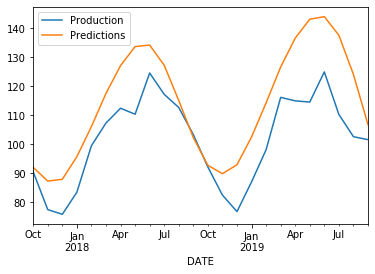

In [52]:
test.plot()

In [58]:
from sklearn.metrics import mean_squared_error, accuracy_score

In [56]:
np.sqrt(mean_squared_error(test['Production'], test['Predictions']))

14.888012882281956